## Barren Plateaus and how to handle them

In [55]:
import qiskit as qk
from qiskit import Aer, QuantumCircuit

from qiskit.circuit import Parameter, ClassicalRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigen_solvers.vqe import VQEResult
from qiskit.algorithms.optimizers import COBYLA
from typing import Tuple, List, Dict, Union
from scipy.optimize import minimize, OptimizeResult
import numpy as np
from random import random
import json
from pprint import pprint
import matplotlib.pyplot as plt
from operator import truediv
from cmath import pi
from random import randint
import os
import time
%matplotlib inline

MUB_CIRC_2_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '2_302')
MUB_CIRC_3_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '3_306')

N_QUBIT_NO_MUB_PATH = 'no_mub_results_n.txt'
NO_MUB_PATH = 'no_mub_results_3.txt'
PRE_MUB_PATH = 'prepend_mub_results_3.txt'
K_PRE_MUB_PATH = 'prepend_k_mub_results_3.txt'
RANDOM_THETAS_PATH_3 = 'random_thetas_results_3.txt'

NO_MUB_GRAPH_FOLDER = '3 qubit graphs'
N_QUBIT_NO_MUB_GRAPH_FOLDER = 'n qubit graphs'

VQC_FOLDER = 'VQC results'

EPS_TOL = 1e-12
LO_TOL = 1e-5
MID_TOL = 1e-2
HI_TOL = 0.2
TINY_SUCCESS_BOUND = 0.01
LO_SUCCESS_BOUND = 0.1
HI_SUCCESS_BOUND = 0.4

SHOTS = 8192
MAX_ITER = 1e8
qasm_backend = Aer.get_backend('qasm_simulator')
qasm_qi = QuantumInstance(qasm_backend, shots=SHOTS)

### Basic Barren Plateau Circuit for Variational Quantum Compilation

The "Cerezo" ansatz circuit is taken from "Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits" by Cerezo et al., 2021, Figure 4.
The "Arrasmith" ansatz circuit is taken from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

The attempted task is "trivial" Variational Quantum Compilation.
Vartational Quantum Compilation gets some unitary $U$, and an ansatz $V(\theta)$, and attempts to find a value for $\theta$ such that $V(\theta)| 0 \rangle = U | 0 \rangle$.

In this case, we choose $U=I$.
Because we pick a *random* initial guess for $\theta$, we will experience the barren plateaus that occur when the $\theta$ values are away from the target.

Note, however, an important observation:
In order to actually use the "value" of the different MUB starting points, the original value of the parameters needs to be constant (although random) for all experiments.

I took this specific problem from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

In [56]:
def gen_vqc_ansatz_cerezo(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)

    idx = 0

    for i in range(n_qubits):
        theta = Parameter(f'theta_{idx}')
        idx += 1
        qc.ry(theta, i)
        

    for layer in range(n_layers):
        for i in range(0, n_qubits-1, 2):
            qc.cz(i, i+1)
        
        for i in range(n_qubits-1):
            theta1 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta1, i)

        for i in range(1, n_qubits-1, 2):
                qc.cz(i, i+1)
            
        for i in range(1, n_qubits):
            theta2 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta2, i)

    qc.measure_all()

    return qc


def gen_vqc_ansatz_arrasmith(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)
    count=1
    for _ in range(n_layers):
        
        # First layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        # First layer of even CXs
        for i in range(0, n_qubits-1, 2):
            qc.cx(i, i+1)
            
        # Second layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        for i in range(1, n_qubits, 2):
            qc.cx(i, (i+1)%n_qubits)
            
    qc.measure_all()
        
    return qc


### Default Experiment Values

In [64]:
optimizer = ''
success_bound = tol = K = N_LAYERS = N_QUBITS= 0
def std_exp_3_qubits():
    global optimizer
    global success_bound
    global tol
    global K
    global N_LAYERS
    global N_QUBITS
    optimizer = 'COBYLA'
    success_bound = LO_SUCCESS_BOUND
    tol = LO_TOL
    K = 25
    N_LAYERS = 12
    N_QUBITS = 3
    
def std_exp_7_qubits():
    global optimizer
    global success_bound
    global tol
    global K
    global N_LAYERS
    global N_QUBITS
    optimizer = 'COBYLA'
    success_bound = LO_SUCCESS_BOUND
    tol = LO_TOL
    K = 25
    N_LAYERS = 7
    N_QUBITS = 7

std_exp_3_qubits()

## Replicating the BPs - no MUBs

#### Experiment Functions

In [58]:
def low_constraint(x: List[float]):
    return min(x)

def hi_constraint(x: List[float]):
    return 2*pi-max(x)

def get_constraints() -> List[dict]:
    return [{'type': 'ineq', 'fun': low_constraint}, {'type': 'ineq', 'fun': hi_constraint}]

def rand_angle():
    return (np.random.random()) * 2 * pi - pi

# Returns the number of function evaluations it took for the method to converge.
# If during the optimization, the cost function goes below a specified bound, the optimization halts.
# If the optimization halted because of the bound, the OptimizeResult is replaced with None.
def run_vqc_exp(qc: QuantumCircuit, theta0: List[float], tol: float = HI_TOL, success_bound: float=0,
                optimizer: str = 'COBYLA', qi: QuantumInstance = qasm_qi, q=0) -> Tuple[List[float], OptimizeResult]:
    class BoundHitException(Exception):
        pass

    n_qubits = qc.num_qubits

    # Calculate the percentage of results where 0 was reached in the jth qubit.
    def get_p0j(counts: dict, j: int, shots: int = SHOTS) -> float:
        assert j >= 0 and j < n_qubits
        count0j = sum([v for k,v in counts.items() if k[j] == '0'])
        assert count0j >= 0 and count0j <= shots
        return count0j / shots
    
    cost_points = []
    cost_grad = []
    def get_val_from_theta(theta: List[float]) -> float:
        cost_grad.append(theta)
        if float('inf') in theta or float('-inf') in theta:
            print(f'inf bug reached in iteration {len(cost_points)}.')
            print('printing 99 last cost points:')
            print(cost_points[-99:])
            print('printing 100 last gradient values:')
            print(cost_grad[-100:])
            raise ZeroDivisionError()
        # if len(cost_points) % 100 == 0 or min(theta) < -0.5 or max(theta) > 2*pi:
        #     print(f'{len(cost_points)}: {theta}')
        concrete_qc = qc.bind_parameters(theta)
        results = qi.execute(concrete_qc)
        counts = dict(results.get_counts())
        
        # Note that the Arrasmith paper uses ONLY the local cost.
        # Also, note that while the initial global cost is close to 1, the initial local cost should be around 0.5.
        # The intuition is that the probability to be in |0> specifically vanishes exponentially,
        # While the amount of "lit" qubits in a random answer should be around half.
        global_cost = 1 - (results.get_counts().int_raw.get(0, 0) / SHOTS)
        local_cost = 1 - sum([get_p0j(counts, j) for j in range(n_qubits)]) / n_qubits
        cost = q*global_cost + (1-q)*local_cost
        cost_points.append(cost)
        
        if (cost) <= success_bound:
            print('Success bound reached. WOOP')
            raise BoundHitException()
        return cost

    try:
        if optimizer == 'COBYLA':
            res = minimize(get_val_from_theta,
                theta0,
                method='COBYLA',
                options={'maxiter': MAX_ITER},
                tol=tol,
                constraints=get_constraints())
        elif optimizer == 'Nelder-Mead':
            res = minimize(get_val_from_theta,
                theta0,
                method='Nelder-Mead',
                options={'maxiter': MAX_ITER},
                tol=tol,
                bounds = [(-pi,pi) for _ in range(len(theta0))])
        elif optimizer == 'SLSQP':
            res = minimize(get_val_from_theta,
                theta0,
                method='SLSQP',
                options={'maxiter': MAX_ITER},
                tol=tol,
                bounds = [(-pi,pi) for _ in range(len(theta0))])
        elif optimizer == 'Powell':
            res = minimize(get_val_from_theta,
                theta0,
                method='Powell',
                options={'maxiter': MAX_ITER},
                tol=tol,
                bounds = [(-pi,pi) for _ in range(len(theta0))])
        else:
            assert 0==1
        
    except BoundHitException:
        return cost_points, True
    except ZeroDivisionError:
        return cost_points, cost_grad
    except KeyboardInterrupt:
        print('Optimization stopped by keyboard interrupt. WOLOLO')
        return cost_points, False

    return cost_points, res

## Experiments

### 3-qubit, n-layer experiments

In [17]:
no_mub_res = {}
start_time = time.time()
for n_layers in range(4, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz_arrasmith(N_QUBITS, n_layers)
    theta0 = [rand_angle() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, theta0, EPS_TOL, success_bound=HI_SUCCESS_BOUND)

    no_mub_res[n_layers] = layer_res
    curr_time = time.time()
    print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
    start_time = curr_time

RUNNING EXPERIMENT FOR 4 LAYERS:
Success bound reached. WOOP
Finished experiment in 0.8246250152587891 seconds at Mon Sep 26 18:50:58 2022
RUNNING EXPERIMENT FOR 5 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 0.8824191093444824 seconds at Mon Sep 26 18:50:59 2022
RUNNING EXPERIMENT FOR 6 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 2.2488491535186768 seconds at Mon Sep 26 18:51:01 2022
RUNNING EXPERIMENT FOR 7 LAYERS:
Success bound reached. WOOP
Finished experiment in 0.16588830947875977 seconds at Mon Sep 26 18:51:02 2022
RUNNING EXPERIMENT FOR 8 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 2.4697563648223877 seconds at Mon Sep 26 18:51:04 2022
RUNNING EXPERIMENT FOR 9 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 3.838423252105713 seconds at Mon Sep 26 18:51:08 2022
RUNNING EXPERIMENT FOR 10 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 1.0427820682525635 seconds at Mon Sep 26 18:51:09 2022
RUNNING EXPERIMENT FOR 11 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 3.73286771774292 seconds at Mon Sep 26 18:51:13 2022
RUNNING EXPERIMENT FOR 12 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 5.108753681182861 seconds at Mon Sep 26 18:51:18 2022


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


### n-qubit, n-layer experiments

In [5]:
std_exp()
tol=LO_TOL
success_bound=HI_SUCCESS_BOUND

In [15]:
n_qubit_no_mub_res = {}
start_time = time.time()
first_time = start_time
curr_time = first_time
for n_layers in range(4, 10):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz_arrasmith(n_layers, n_layers)
    theta0 = [rand_angle() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, theta0, tol=tol, success_bound=success_bound, optimizer=optimizer, q=0.1)

    n_qubit_no_mub_res[n_layers] = layer_res
    curr_time = time.time()
    print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
    start_time = curr_time
    
    if layer_res[1] == False: # Signifying keyboard interrupt
        break
    elif layer_res[1] == True:
        layer_res = (layer_res[0], [])
    
print(f'entire thing took {curr_time-first_time} seconds')

RUNNING EXPERIMENT FOR 4 LAYERS:
Success bound reached. WOOP
Finished experiment in 1.719634771347046 seconds at Thu Sep 29 12:08:03 2022
RUNNING EXPERIMENT FOR 5 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 9.289123058319092 seconds at Thu Sep 29 12:08:13 2022
RUNNING EXPERIMENT FOR 6 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 11.878880500793457 seconds at Thu Sep 29 12:08:25 2022
RUNNING EXPERIMENT FOR 7 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 174.3855221271515 seconds at Thu Sep 29 12:11:19 2022
RUNNING EXPERIMENT FOR 8 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
Finished experiment in 863.3210775852203 seconds at Thu Sep 29 12:25:42 2022
RUNNING EXPERIMENT FOR 9 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Finished experiment in 9002.886948347092 seconds at Thu Sep 29 14:55:45 2022
entire thing took 10063.481186389923 seconds


##### TO DELETE

In [15]:
n_qubit_no_mub_res_cobyla = {}
n_qubit_no_mub_res_powell = {}
start_time = time.time()
first_time = start_time
curr_time = first_time

n_layers = 8
print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
qc = gen_vqc_ansatz_arrasmith(n_layers, n_layers)
theta0 = [rand_angle() for _ in range(qc.num_parameters)]

layer_res_cobyla = run_vqc_exp(qc, theta0, tol=tol, success_bound=success_bound, optimizer='COBYLA')
n_qubit_no_mub_res_cobyla[n_layers] = layer_res
if layer_res[1] == True:
    layer_res = (layer_res[0], [])
curr_time = time.time()
print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
start_time = curr_time


layer_res_powell = run_vqc_exp(qc, theta0, tol=tol, success_bound=success_bound, optimizer='COBYLA')
n_qubit_no_mub_res_powell[n_layers] = layer_res_powell

if layer_res_powell[1] == True:
    layer_res = (layer_res[0], [])

curr_time = time.time()
print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
start_time = curr_time


print(f'entire thing took {curr_time-first_time} seconds')

RUNNING EXPERIMENT FOR 8 LAYERS:
Finished experiment in 2158.095737218857 seconds at Thu Sep 22 15:46:44 2022
entire thing took 2158.095737218857 seconds


### Analysis Functions

In [59]:
def avg(col):
    return sum(col) / len(col) if len(col) > 0 else None

def wavg(col, weights):
    assert len(col) == len(weights)
    return sum([v * w for v,w in zip(col, weights)])


def nfev(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> int:
    evals, record = data
    if evals != []:
        return len(evals)
    elif type(record) == VQEResult:
        return record.cost_function_evals
    else:
        assert type(record) == OptimizeResult
        return record.nfev
    
    
def fin_val(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> int:
    evals, record = data
    if evals != []:
        return evals[-1]
    elif type(record) == VQEResult:
        return record.eigenvalue
    else:
        return record.fun

def plot_and_save_graph(evals: List[float], target_vals: List[float], title: str, filename: str):
    plt.axis([0, len(evals), 0, 1])
    plt.plot(evals)
    plt.title(title)
    
    if target_vals != []:
        plt.plot([0, len(evals)-1], [target_vals[0], target_vals[0]], color='red')
    for fake_target in target_vals[1:]:
        plt.plot([0, len(evals)-1], [target_vals[0], target_vals[0]], color='purple')
        
    plt.savefig(filename)
    plt.show()
    

def gen_statistics_nomub(results_dict: Dict[int, Tuple[List[float], VQEResult]],
                         target_vals: List[float] = [],
                         stats_filename: str = '',
                         stats_folder: str = ''):
    
    res = {l: {'nfev': nfev(res), 'fin_val': fin_val(res), 'evals': res[0]} for l, res in results_dict.items()}
    
    if stats_folder == '':
        stats_folder = input('enter path for results directory')
    if not os.path.isdir(stats_folder):
        os.mkdir(stats_folder)
    if stats_filename == '':
        stats_filename = input('enter filename for statistics file')
    
    with open(os.path.join(stats_folder, stats_filename), 'w') as f:
        pprint(res, f)
        
    for l, data in results_dict.items():
        plot_and_save_graph(evals=data[0],
                            target_vals=target_vals,
                            title=f'Convergence graph with {l} layers',
                            filename=os.path.join(stats_folder, f'{l}.png'))
        
    plt.yscale('log')
    plt.plot(results_dict.keys(), [nfev(v) for v in results_dict.values()])
    plt.title('# of function evals from layer no.')
    plt.savefig(os.path.join(stats_folder, f'nfev_from_layer.png'))
    plt.show()
        
    return res

#### Analysis

In [ ]:
stats_filename = os.path.join(os.getcwd(), VQC_FOLDER, NO_MUB_PATH)
stats_folder = os.path.join(os.getcwd(), VQC_FOLDER, NO_MUB_GRAPH_FOLDER)
no_mub_stats = gen_statistics_nomub(no_mub_res, stats_filename=stats_filename, stats_folder=stats_folder)

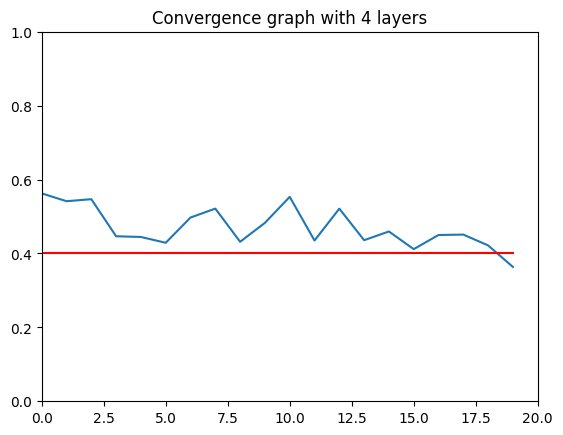

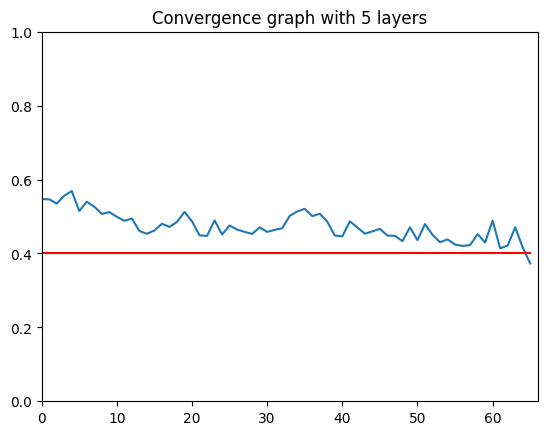

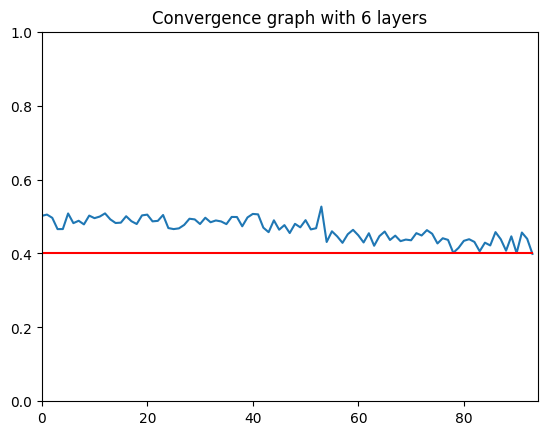

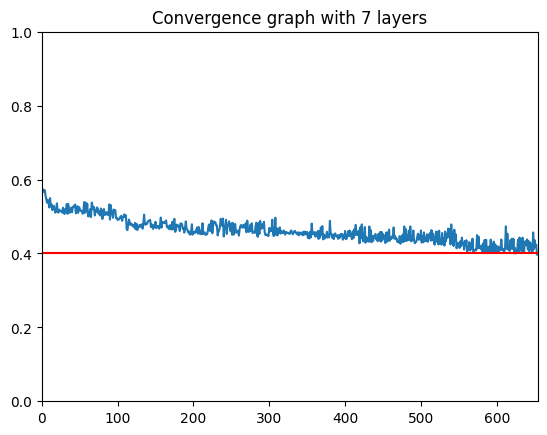

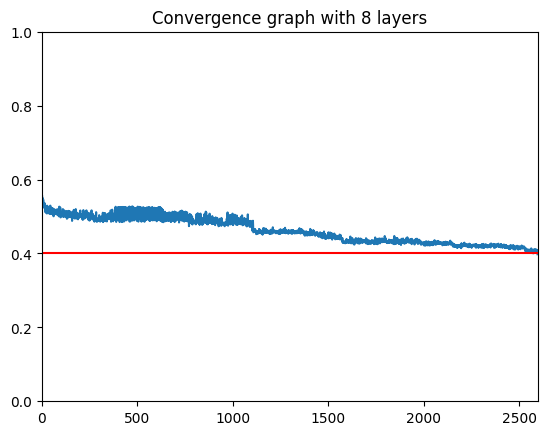

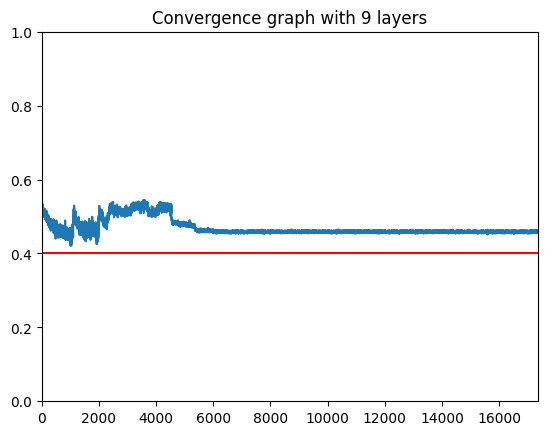

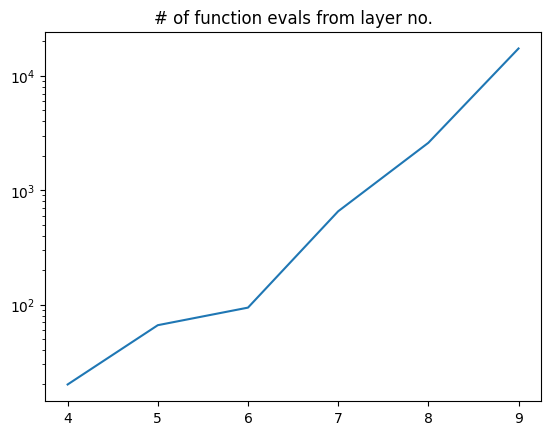

In [17]:
stats_filename = os.path.join(os.getcwd(), VQC_FOLDER, N_QUBIT_NO_MUB_PATH)
stats_folder = os.path.join(os.getcwd(), VQC_FOLDER, N_QUBIT_NO_MUB_GRAPH_FOLDER)
n_qubit_no_mub_stats = gen_statistics_nomub(n_qubit_no_mub_res, target_vals=[success_bound], stats_filename='stats.txt', stats_folder='VQC results/many_qubit_new_lo_tol_hi_succ_q0_4')

In [12]:
stats_filename = os.path.join(os.getcwd(), VQC_FOLDER, N_QUBIT_NO_MUB_PATH)
stats_folder = os.path.join(os.getcwd(), VQC_FOLDER, N_QUBIT_NO_MUB_GRAPH_FOLDER)
n_qubit_no_mub_stats = gen_statistics_nomub(n_qubit_no_mub_res, target_vals=[success_bound], stats_filename='stats.txt', stats_folder='oknow')

FileNotFoundError: [Errno 2] No such file or directory: 'VQC results\\oknow\\stats.txt'

## Experimenting with MUBs - prepending
This is an experiment in which a MUB transformation is applied *before* the ansatz circuits.

### Loading the QASM MUB circuits into Qiskit

In [60]:
CIRC_FROM_FILES = True
if CIRC_FROM_FILES:
    paths_2 = os.listdir(MUB_CIRC_2_PATH)
    paths_3 = os.listdir(MUB_CIRC_3_PATH)
    mub_circuits_2_qubits = [qk.circuit.QuantumCircuit.from_qasm_file(os.path.join(MUB_CIRC_2_PATH,path)) for path in paths_2 if '.txt' in path]
    mub_circuits_3_qubits = [qk.circuit.QuantumCircuit.from_qasm_file(os.path.join(MUB_CIRC_3_PATH,path)) for path in paths_3 if '.txt' in path]
else:
    mub_circuits_2_qubits = [qk.circuit.QuantumCircuit.from_qasm_str(qasm_str) for qasm_str in qasm_2_302.values()]
    mub_circuits_3_qubits = [qk.circuit.QuantumCircuit.from_qasm_str(qasm_str) for qasm_str in qasm_3_306.values()]

### Experiment Functions

In [69]:
# This function gets a number i from 0 to (2^n)-1
# and returns a circuit that generates the state |i> when acting on |0>.
def get_comp_state_circ(state_idx: int, n_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    bin_str = bin(state_idx)[2:].zfill(n_qubits)
    for i, ch in enumerate(bin_str):
        if ch == '1':
            qc.x(i)
    return qc

comp_circuits = [get_comp_state_circ(i, N_QUBITS) for i in range(2 ** N_QUBITS)]

def run_vqc_exp_with_mub_prepend(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit,
                                 n_qubits: int, n_layers: int,
                                 theta0: List[float], tol: float = 0.2,
                                 success_bound: float = 0,
                                 optimizer: str = 'COBYLA',
                                 qi: QuantumInstance = qasm_qi) -> dict:
    mub_qc = mub_qc.copy()
    mub_qc.add_register(ClassicalRegister(n_qubits))
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None

    res_dict = {}
    for i in range((2 ** n_qubits)):
        starting_qc = get_comp_state_circ(i, n_qubits)
        starting_qc.add_register(ClassicalRegister(n_qubits))
        full_qc = starting_qc.compose(mub_ansatz_qc, qubits=range(n_qubits), inplace=False)
        assert full_qc != None
        res_dict[i] = run_vqc_exp(full_qc, theta0, tol, success_bound, optimizer, qi)

    return res_dict


def run_vqc_exp_with_state_prepend(ansatz_qc: QuantumCircuit, state_qc: QuantumCircuit,
                                   n_qubits: int, theta0: List[float],
                                   tol: float = 0.2, success_bound: float=0,
                                   optimizer: str = 'COBYLA',
                                   qi: QuantumInstance = qasm_qi) -> dict:
    state_qc = state_qc.copy()
    state_qc.add_register(ClassicalRegister(n_qubits))
    full_qc = state_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert full_qc != None
    return run_vqc_exp(full_qc, theta0, tol, success_bound, optimizer, qi)

In [68]:
std_exp_3_qubits()

#### Experiments: try k random MUB states

In [66]:
def generate_k_mub_choices(k: int) -> List[Tuple[int, int]]:
    n_mubs = 2 ** N_QUBITS + 1
    n_states = 2 ** N_QUBITS
    assert k <= n_mubs * n_states
    res = []
    while k > 0:
        while True:
            mub = randint(0, n_mubs-1)
            state = randint(0, n_states-1)
            if (mub, state) not in res:
                res.append((mub, state))
                k -= 1
                break
    return res

#### Results Data Structure
The results of the experiment are a dict from the n of layers to the results for that n.

Each layer's results are also a dictionary.
The key is a pair: the first element is the MUB index, and the second is the state index.
The value is a tuple of the convergence graph, and (optionally) the result data structure generated by SciPy.

In [70]:
print('=====Experimenting with SMALL SETS of prepended MUB states=====')
start_time = time.time()
first_time = start_time
curr_time = start_time
k_prepend_mub_results = {}
interrupted = False
# for n_layers in range(4,13):
for n_layers in [N_LAYERS]:
    if interrupted:
        break
    layer_results = {}
    print(f'---starting with {n_layers} layers---')
    ansatz = gen_vqc_ansatz_arrasmith(N_QUBITS, n_layers)
    theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
    state_choices = generate_k_mub_choices(K)
    
    for mub, state in state_choices:
        print(f'experimenting with MUB {mub}, state {state}')
        mub_qc: QuantumCircuit = mub_circuits_3_qubits[mub].copy()
        state_qc: QuantumCircuit = comp_circuits[state].copy()
        full_state_qc = state_qc.compose(mub_qc, inplace=False)
        state_data = run_vqc_exp_with_state_prepend(ansatz, full_state_qc, N_QUBITS, theta0, tol=tol, success_bound=success_bound, optimizer=optimizer)
        print(f'({mub},{state}) done')
        
        if state_data[1] == False: # Signifying keyboard interrupt
            interrupted = True
            break
        elif state_data[1] == True:
            state_data = (state_data[0], [])

        curr_time = time.time()
        print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
        start_time = curr_time
        
        layer_results[(mub, state)] = state_data
        
    k_prepend_mub_results[n_layers] = layer_results
print(f'total took {curr_time - first_time} seconds')

=====Experimenting with SMALL SETS of prepended MUB states=====
---starting with 12 layers---
experimenting with MUB 3, state 3
Success bound reached. WOOP
(3,3) done
Finished experiment in 37.04995346069336 seconds at Sun Oct  2 12:36:33 2022
experimenting with MUB 5, state 4


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(5,4) done
Finished experiment in 45.66779971122742 seconds at Sun Oct  2 12:37:19 2022
experimenting with MUB 6, state 3


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(6,3) done
Finished experiment in 74.68027567863464 seconds at Sun Oct  2 12:38:34 2022
experimenting with MUB 4, state 0


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(4,0) done
Finished experiment in 70.77626371383667 seconds at Sun Oct  2 12:39:45 2022
experimenting with MUB 0, state 3


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(0,3) done
Finished experiment in 26.947118997573853 seconds at Sun Oct  2 12:40:12 2022
experimenting with MUB 2, state 3


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(2,3) done
Finished experiment in 31.092183351516724 seconds at Sun Oct  2 12:40:43 2022
experimenting with MUB 8, state 7


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(8,7) done
Finished experiment in 79.47910475730896 seconds at Sun Oct  2 12:42:02 2022
experimenting with MUB 2, state 2


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(2,2) done
Finished experiment in 39.924880266189575 seconds at Sun Oct  2 12:42:42 2022
experimenting with MUB 0, state 4


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(0,4) done
Finished experiment in 20.556301832199097 seconds at Sun Oct  2 12:43:03 2022
experimenting with MUB 1, state 6


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(1,6) done
Finished experiment in 35.887871980667114 seconds at Sun Oct  2 12:43:38 2022
experimenting with MUB 5, state 3


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(5,3) done
Finished experiment in 48.82663679122925 seconds at Sun Oct  2 12:44:27 2022
experimenting with MUB 1, state 1


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(1,1) done
Finished experiment in 121.18857765197754 seconds at Sun Oct  2 12:46:29 2022
experimenting with MUB 2, state 7


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(2,7) done
Finished experiment in 14.957080602645874 seconds at Sun Oct  2 12:46:43 2022
experimenting with MUB 4, state 1


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(4,1) done
Finished experiment in 41.51728534698486 seconds at Sun Oct  2 12:47:25 2022
experimenting with MUB 7, state 2


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(7,2) done
Finished experiment in 73.99515318870544 seconds at Sun Oct  2 12:48:39 2022
experimenting with MUB 4, state 6


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(4,6) done
Finished experiment in 44.23233485221863 seconds at Sun Oct  2 12:49:23 2022
experimenting with MUB 6, state 5


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(6,5) done
Finished experiment in 20.838406324386597 seconds at Sun Oct  2 12:49:44 2022
experimenting with MUB 8, state 6


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(8,6) done
Finished experiment in 109.48003196716309 seconds at Sun Oct  2 12:51:34 2022
experimenting with MUB 5, state 6


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(5,6) done
Finished experiment in 37.39819288253784 seconds at Sun Oct  2 12:52:11 2022
experimenting with MUB 4, state 4


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(4,4) done
Finished experiment in 22.40269684791565 seconds at Sun Oct  2 12:52:33 2022
experimenting with MUB 6, state 0


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(6,0) done
Finished experiment in 26.621684312820435 seconds at Sun Oct  2 12:53:00 2022
experimenting with MUB 1, state 0


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(1,0) done
Finished experiment in 35.79049468040466 seconds at Sun Oct  2 12:53:36 2022
experimenting with MUB 6, state 6


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(6,6) done
Finished experiment in 20.429171800613403 seconds at Sun Oct  2 12:53:56 2022
experimenting with MUB 6, state 1


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(6,1) done
Finished experiment in 132.10591435432434 seconds at Sun Oct  2 12:56:08 2022
experimenting with MUB 8, state 0


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(8,0) done
Finished experiment in 27.71117401123047 seconds at Sun Oct  2 12:56:36 2022
total took 1239.5565893650055 seconds


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


### Experiments: try k random parameters

#### Result Data Structure

The results of the experiment are a dict from the n of layers (and potentially qubits) to the results for that n.

Each layer's results are a list of tuples.
The first element is the theta vector used for that run.
The second element is a tuple of the convergence graph, and (optionally) the result data structure generated by SciPy.

In [65]:
print('=====Experimenting with SMALL SETS of radnom initial parameters=====')
start_time = time.time()
first_time = start_time
curr_time = start_time
interrupted = False
random_thetas_results = {}
# for n_layers in range(4,11):
for n_layers in [N_LAYERS]:
    if interrupted:
        break
    layer_results = []
    print(f'---experimenting with {n_layers} layers AND QUBITS---')
    ansatz = gen_vqc_ansatz_arrasmith(N_QUBITS, n_layers)
    
    for i in range(K):
        theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
        print(f'experimenting with random parameter set #{i}')
        exp_data = run_vqc_exp(ansatz, theta0, tol=tol, success_bound=success_bound, optimizer=optimizer)
        print(f'parameter set #{i} done')
        layer_results.append((theta0, exp_data))
        
        if exp_data[1] == False: # Signifying keyboard interrupt
            interrupted = True
            break
        elif exp_data[1] == True:
            exp_data = (exp_data[0], [])

        curr_time = time.time()
        print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
        start_time = curr_time
        
    random_thetas_results[n_layers] = layer_results
    
print(f'total took {curr_time - first_time} seconds')

=====Experimenting with SMALL SETS of radnom initial parameters=====
---experimenting with 12 layers AND QUBITS---
experimenting with random parameter set #0
Success bound reached. WOOP
parameter set #0 done
Finished experiment in 34.01172351837158 seconds at Sun Oct  2 11:14:47 2022
experimenting with random parameter set #1


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #1 done
Finished experiment in 31.645395040512085 seconds at Sun Oct  2 11:15:18 2022
experimenting with random parameter set #2


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #2 done
Finished experiment in 36.708011627197266 seconds at Sun Oct  2 11:15:55 2022
experimenting with random parameter set #3


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #3 done
Finished experiment in 17.43773579597473 seconds at Sun Oct  2 11:16:13 2022
experimenting with random parameter set #4


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #4 done
Finished experiment in 53.11573576927185 seconds at Sun Oct  2 11:17:06 2022
experimenting with random parameter set #5


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #5 done
Finished experiment in 34.112181186676025 seconds at Sun Oct  2 11:17:40 2022
experimenting with random parameter set #6


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #6 done
Finished experiment in 20.458192586898804 seconds at Sun Oct  2 11:18:00 2022
experimenting with random parameter set #7


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #7 done
Finished experiment in 60.31921458244324 seconds at Sun Oct  2 11:19:01 2022
experimenting with random parameter set #8


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #8 done
Finished experiment in 34.23561930656433 seconds at Sun Oct  2 11:19:35 2022
experimenting with random parameter set #9


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #9 done
Finished experiment in 48.44948625564575 seconds at Sun Oct  2 11:20:23 2022
experimenting with random parameter set #10


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #10 done
Finished experiment in 64.273934841156 seconds at Sun Oct  2 11:21:28 2022
experimenting with random parameter set #11


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #11 done
Finished experiment in 36.594963788986206 seconds at Sun Oct  2 11:22:04 2022
experimenting with random parameter set #12


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #12 done
Finished experiment in 37.291215896606445 seconds at Sun Oct  2 11:22:41 2022
experimenting with random parameter set #13


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #13 done
Finished experiment in 26.89825963973999 seconds at Sun Oct  2 11:23:08 2022
experimenting with random parameter set #14


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #14 done
Finished experiment in 30.770360708236694 seconds at Sun Oct  2 11:23:39 2022
experimenting with random parameter set #15


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #15 done
Finished experiment in 32.82196521759033 seconds at Sun Oct  2 11:24:12 2022
experimenting with random parameter set #16


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #16 done
Finished experiment in 50.5318922996521 seconds at Sun Oct  2 11:25:03 2022
experimenting with random parameter set #17


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #17 done
Finished experiment in 36.71601915359497 seconds at Sun Oct  2 11:25:39 2022
experimenting with random parameter set #18


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #18 done
Finished experiment in 29.566774129867554 seconds at Sun Oct  2 11:26:09 2022
experimenting with random parameter set #19


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #19 done
Finished experiment in 41.4240448474884 seconds at Sun Oct  2 11:26:50 2022
experimenting with random parameter set #20


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #20 done
Finished experiment in 53.60639309883118 seconds at Sun Oct  2 11:27:44 2022
experimenting with random parameter set #21


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #21 done
Finished experiment in 36.82945990562439 seconds at Sun Oct  2 11:28:21 2022
experimenting with random parameter set #22


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #22 done
Finished experiment in 35.032856702804565 seconds at Sun Oct  2 11:28:56 2022
experimenting with random parameter set #23


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #23 done
Finished experiment in 34.08926343917847 seconds at Sun Oct  2 11:29:30 2022
experimenting with random parameter set #24


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
parameter set #24 done
Finished experiment in 30.81626033782959 seconds at Sun Oct  2 11:30:01 2022
total took 947.7569596767426 seconds


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


In [42]:
print('DONEZO')

DONEZO


### Experiments: Try k half-MUBs

When working with $n$ qubits, there is an exponential number of MUBs, and each MUB has an exponential number of states.

The generation of all of these MUB transformations takes exponential time by itself.

To mitigate that, Tal proposed the following idea:
Pick a pair of qubits in an $n$-qubit register. generate a 2-qubit MUB state between them, and put the rest on 0.

This method has a polynomial amount of states, and spans an interesting part of the space.

In [74]:
def gen_half_mub_circ(n_qubits: int, qubit_1: int, qubit_2: int, mub_no: int, state_no: int, mub_circuits: List[QuantumCircuit]) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    comp_state_qc = get_comp_state_circ(state_no, n_qubits=2)
    qc.compose(comp_state_qc, qubits=[qubit_1, qubit_2], inplace=True)
    qc.compose(mub_circuits[mub_no], qubits=[qubit_1, qubit_2], inplace=True)
    return qc

def gen_k_half_mub_choices(n_qubits: int, k: int) -> List[Tuple[int, int, int, int]]:
    n_mubs = 2 ** 2 + 1
    n_states = 2 ** 2
    # m mubs * (n choose 2) pairs of qubits
    assert k <= n_mubs * n_qubits * (n_qubits-1) // 2
    res = []
    while k > 0:
        while True:
            qubit_1 = randint(0, n_qubits-2)
            qubit_2 = randint(qubit_1+1, n_qubits-1)
            mub = randint(0, n_mubs-1)
            state = randint(0, n_states-1)
            if (mub, state) not in res:
                res.append((qubit_1, qubit_2, mub, state))
                k -= 1
                break
    return res

#### Results Data Structure
The results of the experiment are a dict from the n of layers and qubits to the results for that n.

Each layer's results are also a dictionary.
The key is a 4-tuple: the two first places are the pairs of qubits on which the MUB state was generated, the third is the MUB index, and the fourth is the state index.
The value is a tuple of the convergence graph, and (optionally) the result data structure generated by SciPy.

In [75]:
std_exp_7_qubits()

In [76]:
# use qasm
# optimizer = 'SLSQP'
print('=====Experimenting with SMALL SETS of prepended half-MUB states=====')
start_time = time.time()
k_prepend_half_mub_results = {}
interrupted = False
# for n_layers in range(4,13):
for n_layers in [N_LAYERS]:
    if interrupted:
        break
    layer_results = {}
    print(f'---starting with {n_layers} layers---')
    ansatz = gen_vqc_ansatz_arrasmith(n_layers, n_layers)
    theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
    state_choices = gen_k_half_mub_choices(n_qubits=n_layers, k=K)
    
    for choice in state_choices:
        print(f'experimenting with pair {(choice[0], choice[1])}, MUB {choice[2]}, state {choice[3]}')
        full_state_qc = gen_half_mub_circ(n_layers, *choice, mub_circuits_2_qubits)
        state_data = run_vqc_exp_with_state_prepend(ansatz, full_state_qc, n_layers, theta0, tol=tol, success_bound=success_bound, optimizer=optimizer)
        print(f'{choice} done')
        
        if state_data[1] == False: # Signifying keyboard interrupt
            interrupted = True
            break
        elif state_data[1] == True:
            state_data = (state_data[0], [])

        curr_time = time.time()
        print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
        start_time = curr_time
        
        layer_results[choice] = state_data
        
    k_prepend_half_mub_results[n_layers] = layer_results

=====Experimenting with SMALL SETS of prepended half-MUB states=====
---starting with 7 layers---
experimenting with pair (3, 5), MUB 4, state 1
(3, 5, 4, 1) done
Finished experiment in 4464.589127063751 seconds at Sun Oct  2 18:41:05 2022
experimenting with pair (1, 3), MUB 3, state 0
(1, 3, 3, 0) done
Finished experiment in 4067.239604949951 seconds at Sun Oct  2 19:48:52 2022
experimenting with pair (3, 4), MUB 3, state 3
Success bound reached. WOOP
(3, 4, 3, 3) done
Finished experiment in 1222.4300150871277 seconds at Sun Oct  2 20:09:15 2022
experimenting with pair (2, 4), MUB 3, state 3


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


(2, 4, 3, 3) done
Finished experiment in 10183.241861820221 seconds at Sun Oct  2 22:58:58 2022
experimenting with pair (1, 4), MUB 2, state 1
(1, 4, 2, 1) done
Finished experiment in 3681.626673221588 seconds at Mon Oct  3 00:00:20 2022
experimenting with pair (1, 4), MUB 2, state 1
(1, 4, 2, 1) done
Finished experiment in 2938.6972031593323 seconds at Mon Oct  3 00:49:18 2022
experimenting with pair (0, 3), MUB 4, state 1
(0, 3, 4, 1) done
Finished experiment in 3164.930941581726 seconds at Mon Oct  3 01:42:03 2022
experimenting with pair (1, 6), MUB 0, state 3
(1, 6, 0, 3) done
Finished experiment in 4484.523406744003 seconds at Mon Oct  3 02:56:48 2022
experimenting with pair (5, 6), MUB 4, state 0
(5, 6, 4, 0) done
Finished experiment in 3773.793389081955 seconds at Mon Oct  3 03:59:42 2022
experimenting with pair (2, 3), MUB 1, state 3
(2, 3, 1, 3) done
Finished experiment in 4631.130396127701 seconds at Mon Oct  3 05:16:53 2022
experimenting with pair (3, 6), MUB 0, state 3
Succ

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(2, 3, 3, 0) done
Finished experiment in 1579.2565660476685 seconds at Mon Oct  3 06:02:52 2022
experimenting with pair (1, 6), MUB 2, state 3


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(1, 6, 2, 3) done
Finished experiment in 1114.8073308467865 seconds at Mon Oct  3 06:21:27 2022
experimenting with pair (5, 6), MUB 3, state 2


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Success bound reached. WOOP
(5, 6, 3, 2) done
Finished experiment in 1508.6094624996185 seconds at Mon Oct  3 06:46:35 2022
experimenting with pair (2, 6), MUB 2, state 2


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


(2, 6, 2, 2) done
Finished experiment in 3136.8100764751434 seconds at Mon Oct  3 07:38:52 2022
experimenting with pair (2, 6), MUB 4, state 1
(2, 6, 4, 1) done
Finished experiment in 5693.02711391449 seconds at Mon Oct  3 09:13:45 2022
experimenting with pair (0, 2), MUB 3, state 2
(0, 2, 3, 2) done
Finished experiment in 4086.516410112381 seconds at Mon Oct  3 10:21:52 2022
experimenting with pair (1, 2), MUB 4, state 1
(1, 2, 4, 1) done
Finished experiment in 4339.66480922699 seconds at Mon Oct  3 11:34:11 2022
experimenting with pair (2, 5), MUB 3, state 3
Success bound reached. WOOP
(2, 5, 3, 3) done
Finished experiment in 1425.7073812484741 seconds at Mon Oct  3 11:57:57 2022
experimenting with pair (4, 5), MUB 4, state 1


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


(4, 5, 4, 1) done
Finished experiment in 4055.5282170772552 seconds at Mon Oct  3 13:05:33 2022
experimenting with pair (1, 2), MUB 4, state 3
(1, 2, 4, 3) done
Finished experiment in 3836.1265625953674 seconds at Mon Oct  3 14:09:29 2022
experimenting with pair (4, 6), MUB 4, state 1
(4, 6, 4, 1) done
Finished experiment in 5447.402956008911 seconds at Mon Oct  3 15:40:16 2022
experimenting with pair (4, 5), MUB 2, state 3
(4, 5, 2, 3) done
Finished experiment in 4184.101464271545 seconds at Mon Oct  3 16:50:00 2022
experimenting with pair (5, 6), MUB 0, state 3
(5, 6, 0, 3) done
Finished experiment in 4038.9849507808685 seconds at Mon Oct  3 17:57:19 2022
experimenting with pair (3, 4), MUB 2, state 0
Success bound reached. WOOP
(3, 4, 2, 0) done
Finished experiment in 990.4312841892242 seconds at Mon Oct  3 18:13:50 2022


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


### Analysis Functions

In [71]:
# Analyze the performance of using MUB states as initial states for an ansatz
def gen_statistics_prepending(prepend_results_dict: Dict[int, Dict[Tuple[int, int], Tuple[List[float], VQEResult]]],
                              no_mub_stats: Dict[int, Dict[str, int]],
                              target_vals: List[float] = [0],
                              stats_folder: str = '',
                              stats_filename: str = '') -> Dict[int, Dict[str, any]]:
    
    if stats_folder == '':
        stats_folder = input('enter path for results directory')
        if not os.path.isdir(stats_folder):
            os.mkdir(stats_folder)
    if stats_filename == '':
        stats_filename = input('enter filename for statistics file')

    prepend_stats = {}
    for l, d_l in prepend_results_dict.items():
        layer_stats = {}
        min_nfev = min([nfev(state_data) for state_data in d_l.values()])
        layer_stats['min_nfev'] = min_nfev
        layer_stats['avg_nfev'] = avg([nfev(state_data) for state_data in d_l.values()])

        # # Experiments with smaller convergence time
        # adv_states = {state_idx: nfev(state_data) for state_idx, state_data in d_l.items() if nfev(state_data) < no_mub_stats[l]['nfev']}
        # layer_stats['adv_states'] = adv_states
        # layer_stats['adv_states_count'] = len(adv_states)
        # layer_stats['adv_addition_percent'] = len(adv_states) / len(d_l)
        # layer_stats['adv_avg_nfev'] = avg(adv_states.values())
            
        assert target_vals != []
        success_bound = target_vals[0]
        # Experiments that terminated closer to the intended result
        correct_states = {state: fin_val(state_data) for state_idx, state_data in d_l.items() if abs(fin_val(state_data)-success_bound) < 1e-2}        
        layer_stats['correct_states'] = correct_states
        layer_stats['correct_states_count'] = len(correct_states)
        layer_stats['correct_addition_percent'] = len(correct_states) / len(d_l)
        layer_stats['correct_avg_val'] = avg(correct_states.values())
        
        layer_stats['evals'] = {k: v[0] for k,v in d_l.items()}
        layer_stats['nfevs'] = {k: len(v[0]) for k,v in d_l.items()}
        layer_stats['fin_vals'] = {k: fin_val(v) for k,v in d_l.items()}
        prepend_stats[l] = layer_stats
        
    with open(os.path.join(stats_folder, stats_filename), 'w') as f:
        pprint(prepend_stats, f)
        
    for l, d_l in prepend_results_dict.items():
        for idx, data in d_l.items():
            plot_and_save_graph(evals=data[0],
                                target_vals=target_vals,
                                title=f'Convergence graph with {l} layers, state {idx}',
                                filename=os.path.join(stats_folder, f'{l},{idx[0]},{idx[1]}.png'))
    return prepend_stats

def gen_statistics_random_thetas(random_thetas_results_dict: Dict[int, List[Tuple[List[float],Tuple[List[float], VQEResult]]]],
                                 no_mub_stats: Dict[int, Dict[str, int]],
                                 target_vals: List[float] = [0],
                                 stats_folder: str = '',
                                 stats_filename: str = '') -> Dict[int, Dict[str, any]]:
    
    if stats_folder == '':
        stats_folder = input('enter path for results directory')
    if not os.path.isdir(stats_folder):
        os.mkdir(stats_folder)
    if stats_filename == '':
        stats_filename = input('enter filename for statistics file')
        
    assert target_vals != []
    success_bound = target_vals[0]
    
    random_thetas_stats = {}
    for l, list_l in random_thetas_results.items():
        layer_stats = {}
        min_nfev = min([nfev(exp_data) for _, exp_data in list_l])
        layer_stats['min_nfev'] = min_nfev
        layer_stats['avg_nfev'] = avg([nfev(exp_data) for _, exp_data in list_l])
        correct_thetas = [fin_val(exp_data) for _, exp_data in list_l if abs(fin_val(exp_data)-success_bound) < 1e-2]
        layer_stats['correct_thetas_count'] = len(correct_thetas)
        layer_stats['correct_addition_percent'] = len(correct_thetas) / len(list_l)
        layer_stats['correct_avg_val'] = avg(correct_thetas)
        
        layer_stats['evals'] = {k: v[1][0] for k,v in enumerate(list_l)}
        layer_stats['nfevs'] = {k: len(v[1][0]) for k,v in enumerate(list_l)}
        layer_stats['fin_vals'] = {k: fin_val(v[1]) for k,v in enumerate(list_l)}
        random_thetas_stats[l] = layer_stats
        
    with open(os.path.join(stats_folder, stats_filename), 'w') as f:
        pprint(random_thetas_stats, f)
        
    for l, d_l in random_thetas_stats.items():
        for idx, evals in d_l['evals'].items():
            plot_and_save_graph(evals=evals,
                            target_vals=target_vals,
                            title=f'Convergence graph with {l} layers, theta #{idx}',
                            filename=os.path.join(stats_folder, f'{l},{idx}.png'))
    
    return random_thetas_stats

def gen_statistics_half_mubs(half_mubs_results_dict: Dict[int, Dict[Tuple[int, int], Tuple[List[float], VQEResult]]],
                             no_mub_stats: Dict[int, Dict[str, int]],
                             target_vals: List[float] = [0],
                             stats_folder: str = '',
                             stats_filename: str = '') -> Dict[int, Dict[str, any]]:
    
    if stats_folder == '':
        stats_folder = input('enter path for results directory')
        if not os.path.isdir(stats_folder):
            os.mkdir(stats_folder)
    if stats_filename == '':
        stats_filename = input('enter filename for statistics file')

    half_mub_stats = {}
    for l, d_l in half_mubs_results_dict.items():
        layer_stats = {}
        min_nfev = min([nfev(state_data) for state_data in d_l.values()])
        layer_stats['min_nfev'] = min_nfev
        layer_stats['avg_nfev'] = avg([nfev(state_data) for state_data in d_l.values()])
        
        assert target_vals != []
        success_bound = target_vals[0]
        # Experiments that terminated closer to the intended result
        correct_states = {choice: fin_val(state_data) for choice, state_data in d_l.items() if abs(fin_val(state_data)-success_bound) < 1e-2}        
        layer_stats['correct_states'] = correct_states
        layer_stats['correct_states_count'] = len(correct_states)
        layer_stats['correct_addition_percent'] = len(correct_states) / len(d_l)
        layer_stats['correct_avg_val'] = avg(correct_states.values())
        
        layer_stats['evals'] = {k: v[0] for k,v in d_l.items()}
        layer_stats['nfevs'] = {k: len(v[0]) for k,v in d_l.items()}
        layer_stats['fin_vals'] = {k: fin_val(v) for k,v in d_l.items()}
        half_mub_stats[l] = layer_stats
        
    with open(os.path.join(stats_folder, stats_filename), 'w') as f:
        pprint(half_mub_stats, f)
        
    for l, d_l in half_mubs_results_dict.items():
        for idx, data in d_l.items():
            plot_and_save_graph(evals=data[0],
                                target_vals=target_vals,
                                title=f'Convergence graph with {l} layers, pair ({idx[0]},{idx[1]}), MUB state({idx[2]},{idx[3]})',
                                filename=os.path.join(stats_folder, f'{l},{idx[0]},{idx[1]},{idx[2]},{idx[3]}.png'))
    return half_mub_stats

### Analysis

In [ ]:
prepending_stats = gen_statistics_prepending(k_prepend_mub_results,
                                             {},
                                             target_vals=[success_bound])

In [ ]:
k_random_stats = gen_statistics_random_thetas(random_thetas_results,
                                              {},
                                              target_vals=[success_bound],
                                             stats_folder='VQC results/local_cost_bps_3_qubits',
                                             stats_filename='stats.txt')

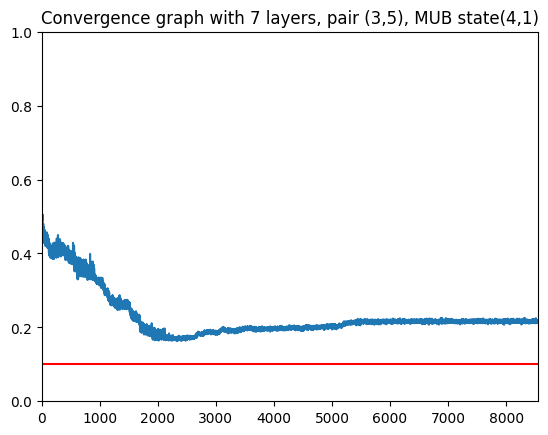

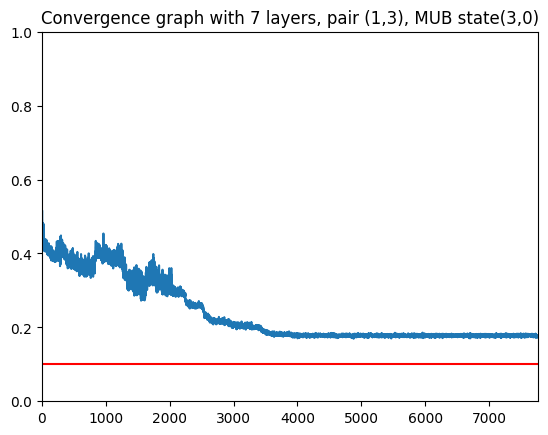

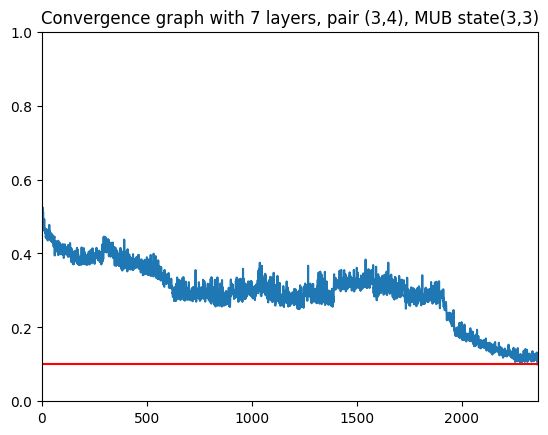

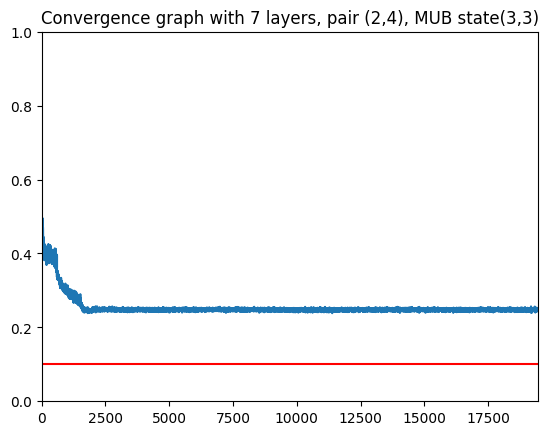

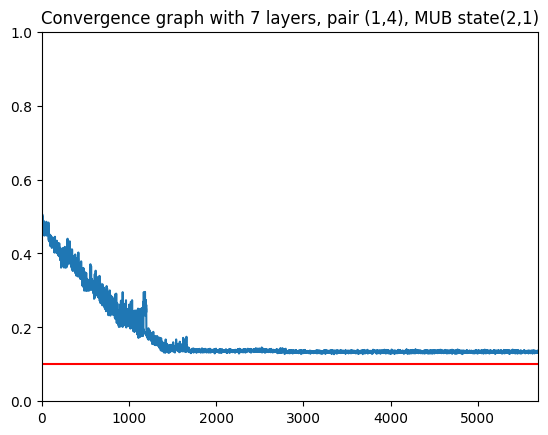

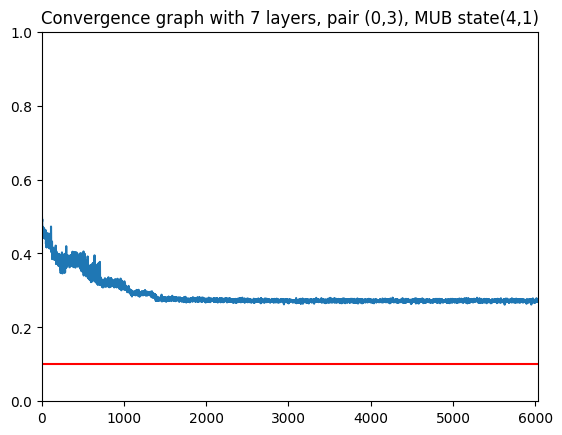

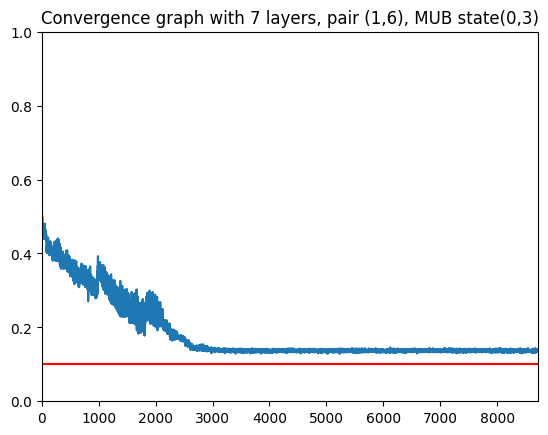

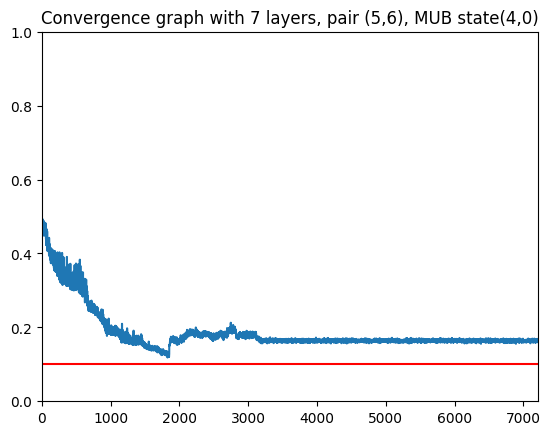

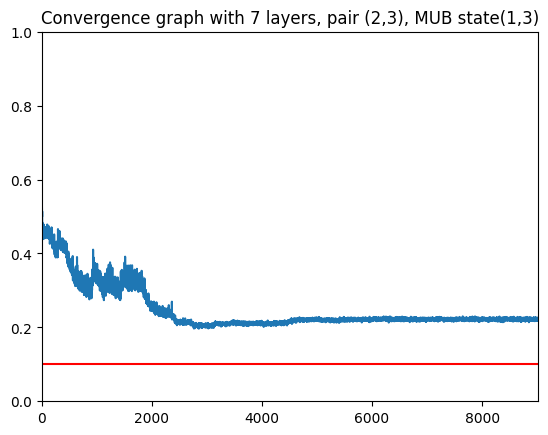

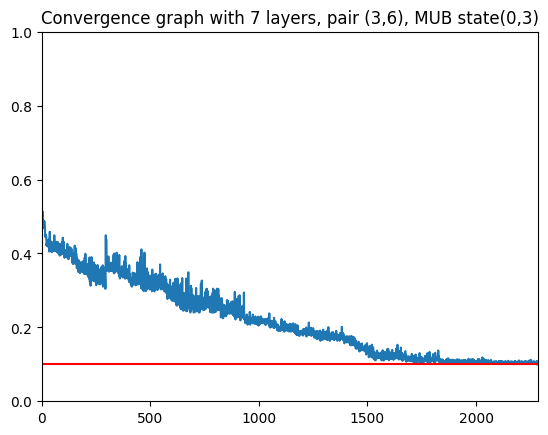

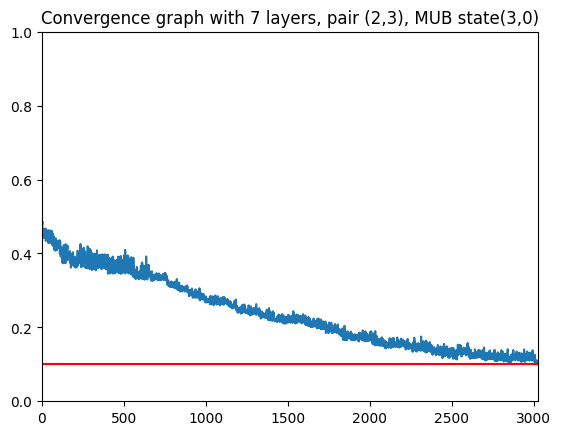

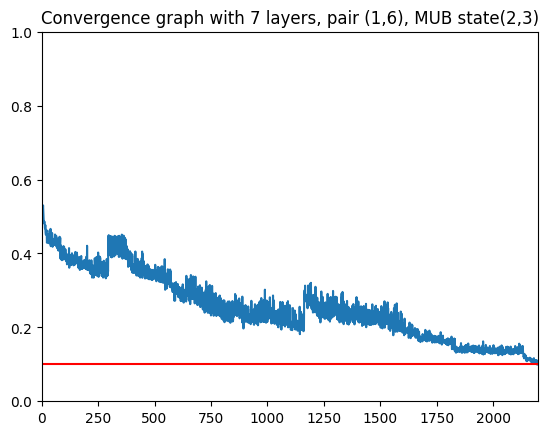

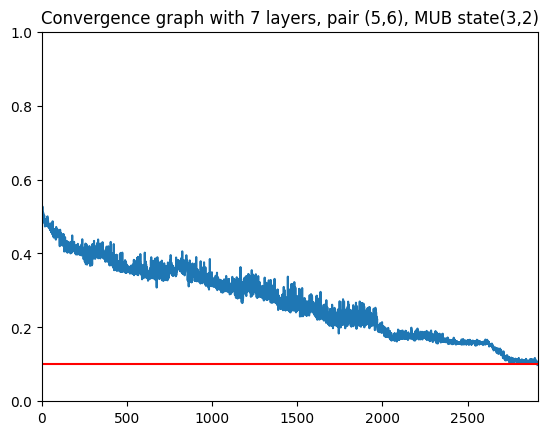

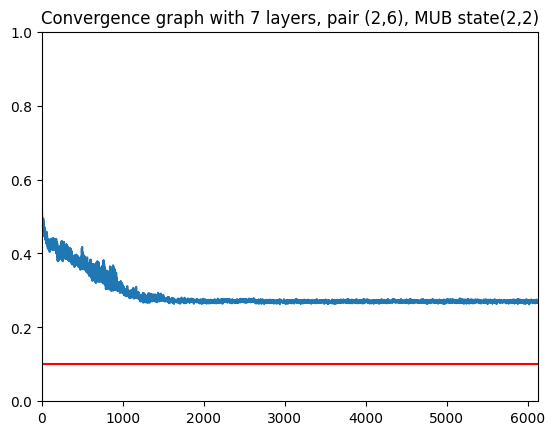

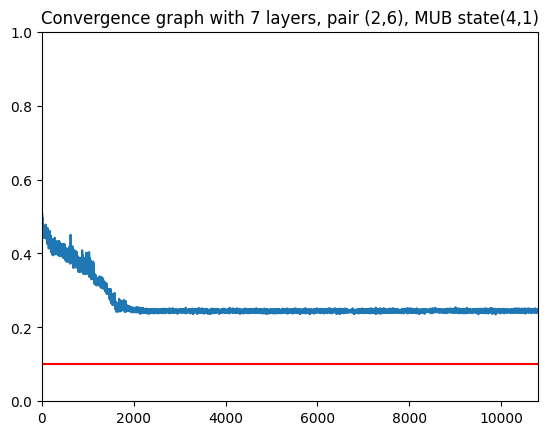

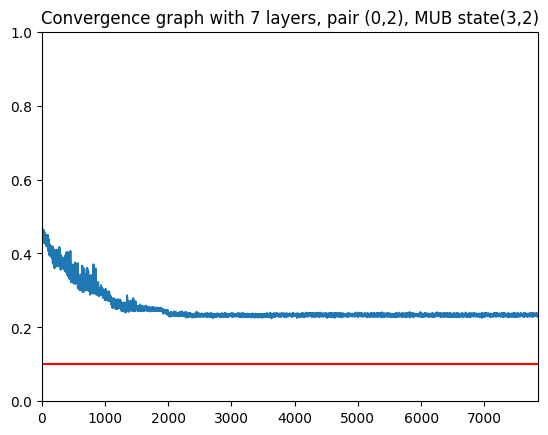

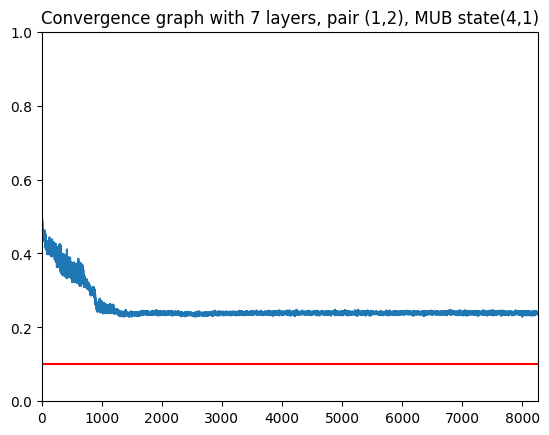

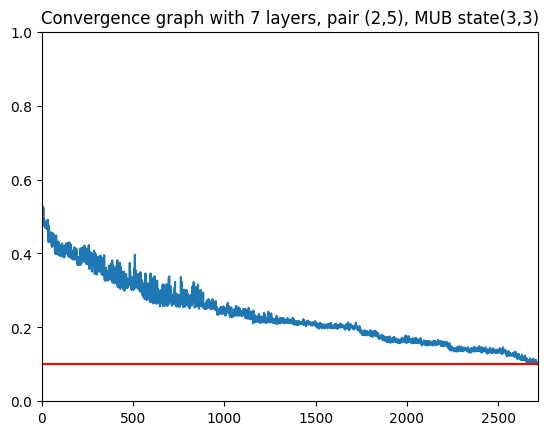

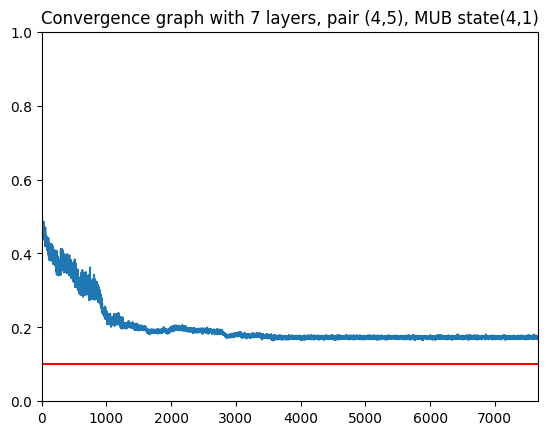

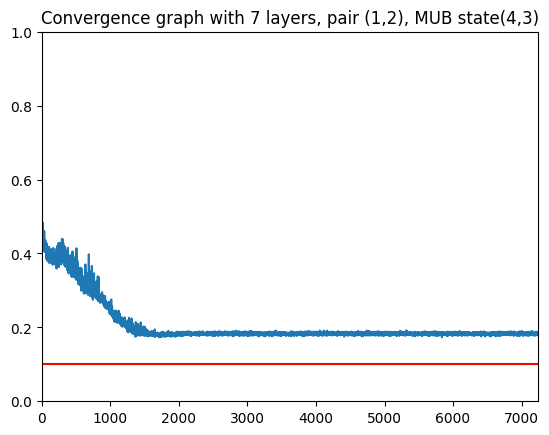

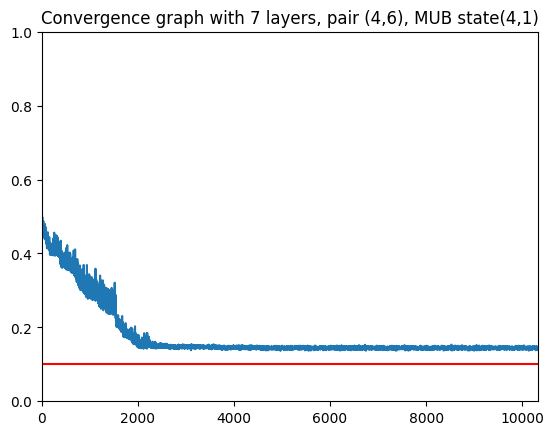

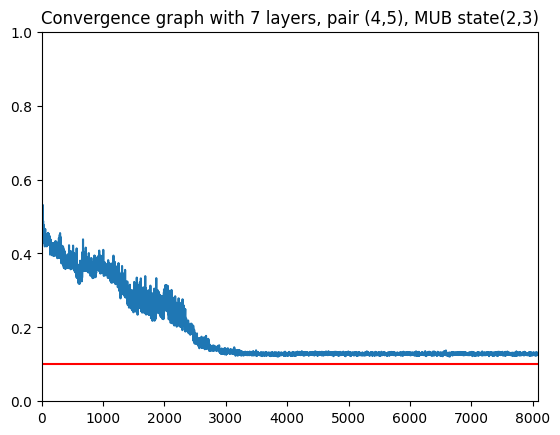

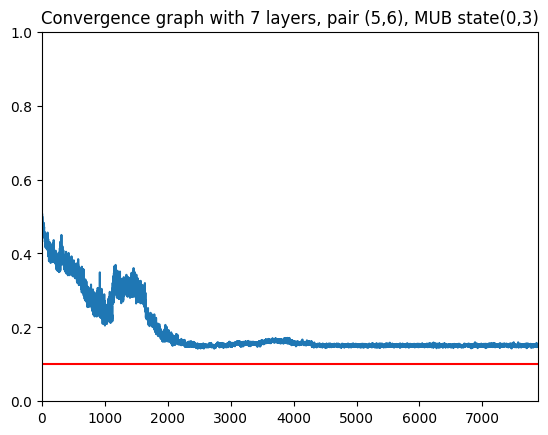

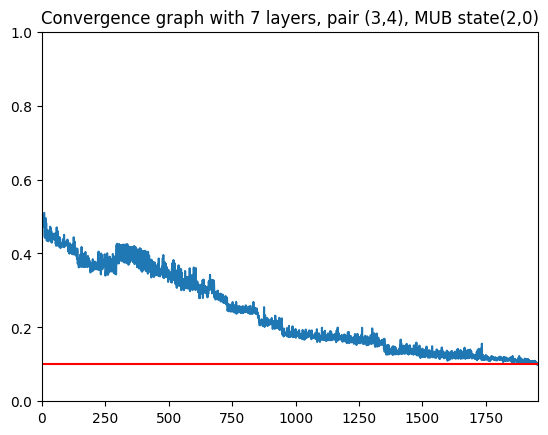

In [78]:
half_mub_stats = gen_statistics_half_mubs(k_prepend_half_mub_results,
                                          {},
                                          target_vals=[success_bound],
                                         stats_folder='VQC results/BBB',
                                         stats_filename = 'bbb.txt')

## Collective Experiments - VQC

### Plotting Functions

In [137]:
def myplot(data: dict, label: str):
    data = {k: v for k,v in data.items() if v != None}
    lists = sorted(data.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y, label=label, marker='o')

def myplot_heatmap(data: list, true_sol: float, false_sols: list = [], val_range=(-0.1, 0.7), bin_count=50, title=""):
    plt.hist(data, bin_count, range=val_range, color='blue')

    # Add Correct Result Line
    plt.plot([true_sol,true_sol], [0,10], color='green', linewidth=1)

    for val in false_sols:
        plt.plot([val, val], [0,10], color='red', linewidth=1)

    plt.title(title)
    plt.show()
    

### (Optionally) Load Data Fom Files

In [ ]:
from ast import literal_eval

STATS_FROM_FILES = True

def load_stats(name: str) -> dict:
    filename = os.path.join(os.getcwd(), VQC_FOLDER, name)
    with open(filename, 'r') as f:
        data = f.read()
    
    return literal_eval(data)

if STATS_FROM_FILES:
    no_mub_stats = load_stats(NO_MUB_PATH)
    prepend_stats = load_stats(PRE_MUB_PATH)

### Raw Summary Data

In [ ]:
print('No MUBs:')
print(no_mub_stats)
print('Prepended MUB states:')
print(prepend_stats)

In [ ]:
# plt.hist([layer['fin_val'] for layer in no_mub_stats.values()], 50, range=(-0.1, 0.5), density=True)
# plt.plot([0,0], [0,5])
# plt.title('final values without MUBS')
# plt.show()

# for layer, layer_stats in prepend_stats.items():
#     plt.hist(layer_stats['fin_vals'], 50, range=(-0.1, 0.5), density=True)

#     # Add Correct Result Line
#     plt.plot([0,0], [0,30], color='green', linewidth=1)
#     plt.title(f'function evaluations for {layer} layers')
#     plt.show()

myplot_heatmap([layer['fin_val'] for layer in no_mub_stats.values()], 0.0, title='final values without using MUBs', bin_count=50)
for layer, layer_stats in prepend_stats.items():
    myplot_heatmap(layer_stats['fin_vals'], 0.0, title=f'function evaluations for {layer} layers', bin_count=50)



### Minimal \# Of Function Evals

In [ ]:
def plot_min_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    for v in stats_dict.values():
        assert 'min_nfev' in v.keys() or 'nfev' in v.keys()
    nfev_dict = {k: v['min_nfev'] if 'min_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Minimal # of Function Evals per layer')
plot_min_nfev(no_mub_stats, "No MUBs")
plot_min_nfev(prepend_stats, "Prepended MUB states")
plot_min_nfev(append_stats, "Appended MUB trans.")
plt.legend()
plt.show()

### Average \# Of Function Evals

In [ ]:
def plot_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    avg_nfev_dict = {k: v['avg_nfev'] if 'avg_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(avg_nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Average # of Function Evals per layer')
plot_avg_nfev(no_mub_stats, "No MUBs")
plot_avg_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Percent of Advantageous Additions

In [ ]:
def plot_adv_percent(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_addition_percent'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Fraction of Advantageous Additions')
plt.title('Fraction of Advantageous Additions')
plot_adv_percent(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Average \# Of Function Evals in Advantageous Additions

In [ ]:
def plot_adv_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_avg_nfev'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Average Function Evals for advantageous additions')
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_adv_avg_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Summary: MUB Prepending

In [ ]:
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_min_nfev(prepend_stats, 'Minimal Function Evals')
plot_avg_nfev(prepend_stats, 'Average Function Evals')
plot_adv_avg_nfev(prepend_stats, 'Average Adventageous NFEV')
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Function Eval data for Prepended States')
plt.legend()
plt.show()

## Basic Barren Plateau Circuit for Transverse Ising VQE
To save myself some time, I'll just use the built-in VQE module.

In [108]:
def build_pauli_string(n_qubits: int, mat_locations: Dict[int, str]) -> str:
    assert n_qubits > 0
    H = ''
    for i in range(n_qubits):
        H += mat_locations.get(i, 'I')
    return H

def generate_transverse_ising_ham(n_qubits: int) -> PauliSumOp:
    # Build Individual X strings
    string_list = [(build_pauli_string(n_qubits, {i: 'X'}), random()) for i in range(n_qubits)]
    for i in range(n_qubits):
        string_list += [(build_pauli_string(n_qubits, {i: 'Z', j: 'Z'}), random()) for j in range(i+1, n_qubits)]
    return PauliSumOp.from_list(string_list, 1)

In [ ]:
# Note that the ansatz structure is identical, only that there is no basic measurement at the end.

def gen_vqe_ansatz_cerezo(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)

    idx = 0

    for i in range(n_qubits):
        theta = Parameter(f'theta_{idx}')
        idx += 1
        qc.ry(theta, i)
        

    for layer in range(n_layers):
        for i in range(0, n_qubits-1, 2):
            qc.cz(i, i+1)
        
        for i in range(n_qubits-1):
            theta1 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta1, i)

        for i in range(1, n_qubits-1, 2):
                qc.cz(i, i+1)
            
        for i in range(1, N_QUBITS):
            theta2 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta2, i)

    return qc


def gen_vqe_ansatz_arrasmith(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)
    count=1
    for _ in range(n_layers):
        
        # First layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        # First layer of even CXs
        for i in range(0, n_qubits-1, 2):
            qc.cx(i, i+1)
            
        # Second layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        for i in range(1, n_qubits, 2):
            qc.cx(i, (i+1)%n_qubits)
            
    qc.measure_all()
        
    return qc


### Experimenting without MUBs

#### Experiment Functions

In [106]:
# Returns the number of function evaluations it took for the method to converge.
def run_vqe_exp(ansatz: QuantumCircuit, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = HI_TOL) -> Tuple[List[float], VQEResult]:
    cost_points = []
    
    def callback(nfev: int, params: np.ndarray, mean: float, std_dev: float):
        cost_points.append(mean)
        
    
    optimizer = COBYLA(maxiter=MAX_ITER, tol=tol)
    vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=qi, initial_point=np.asarray(theta0), callback=callback)
    result = vqe.compute_minimum_eigenvalue(operator=ham)
    return cost_points, result

#### Experiments

In [ ]:
no_mub_res_vqe = {}

for n_layers in range(4, 13):
    print(f'RUNNING VQE EXPERIMENT FOR {n_layers} LAYERS:')
    # n_qubits = n_layers
    ham = generate_transverse_ising_ham(N_QUBITS)
    ansatz = gen_hardware_eff_ansatz(N_QUBITS, n_layers)
#     theta0 = [(np.random.random()) * 2 * pi - pi for _ in range(ansatz.num_parameters)]
    theta0 = [0 for _ in range(ansatz.num_parameters)]
    layer_res = run_vqe_exp(ansatz, ham, theta0=theta0, tol=LO_TOL)
    no_mub_res_vqe[n_layers] = layer_res

In [110]:
eigen_values, eigen_vectors = np.linalg.eigh(ham.to_matrix())

In [67]:
exact_result = eigen_values[0]
print(f"The exact result is: {exact_result}")
print(f"The excited states are: {eigen_values[1:]}")

The exact result is: -2.611073908575124
The excited states are: [-1.75710396 -0.76553487 -0.13554306  0.18934452  0.5137937   1.90793569
  2.65818189]


#### Analysis

In [102]:
# calculate the error from the exact result
for i in range(4, 13):
    print("Error for layer number " + str(i) +": " + str(abs(no_mub_res_vqe[i].eigenvalue - exact_result)))

Error for layer number 4: 0.24741949013293674
Error for layer number 5: 0.42165700401507644
Error for layer number 6: 0.6261742020762586
Error for layer number 7: 0.4706022584405041
Error for layer number 8: 0.21401529415827358
Error for layer number 9: 1.1897460560061148
Error for layer number 10: 0.36511685386935877
Error for layer number 11: 0.055285308974512226
Error for layer number 12: 0.1638953533226779


In [ ]:
filename = os.path.join(os.getcwd(), 'VQE results', NO_MUB_PATH)
no_mub_stats = gen_statistics_nomub(no_mub_res_vqe, filename=filename)
print(no_mub_stats)
myplot_heatmap([layer['fin_val'] for layer in no_mub_stats.values()], exact_result, eigen_values[1:])


### Experimenting with MUBs - prepending (VQE)

#### Experiment Functions

In [140]:
def run_vqe_exp_with_mub_prepend(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit, n_qubits: int, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = 0.2) -> dict:
    mub_qc = mub_qc.copy()
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None

    res_dict = {}
    for i in range((2 ** n_qubits)):
        starting_qc = get_comp_state_circ(i, n_qubits)
        full_qc = starting_qc.compose(mub_ansatz_qc, qubits=range(n_qubits), inplace=False)
        assert full_qc != None
        res_dict[i] = run_vqe_exp(full_qc, ham, theta0=theta0, tol=tol)

    return res_dict

#### Experiments

In [ ]:
print('=====Experimenting with prepended MUB states=====')
ham = generate_transverse_ising_ham(N_QUBITS)
all_prepend_mub_results_vqe = {}

for n_layers in range(4,13):
    print(f'---experimenting with {n_layers} layers---')
    layer_results_vqe = {}
    ansatz = gen_hardware_eff_ansatz(N_QUBITS, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    for i, mub_circuit in enumerate(mub_circuits_3_qubits):
        print(f'experimenting with MUB #{i+1}')
        res = run_vqe_exp_with_mub_prepend(ansatz, mub_circuit, N_QUBITS, ham, theta0=theta0, tol=LO_TOL)
        print(f'MUB #{i+1} done')
        layer_results_vqe[i] = res
    all_prepend_mub_results_vqe[n_layers] = layer_results_vqe

#### Analysis

In [ ]:
filename = os.path.join(os.getcwd(), 'VQE results', PRE_MUB_PATH)
prepend_stats = gen_statistics_prepending(all_prepend_mub_results_vqe, no_mub_stats, filename=filename)

### Note
I changed the random initial state for layers 4,5,12 and 6,7,8 and 9,10,11 to see that the result is changing drastically by the random choice

In [ ]:
for key in all_prepend_mub_results_vqe.keys():
    for key2 in all_prepend_mub_results_vqe[key].keys():
        for key3 in all_prepend_mub_results_vqe[key][key2].keys():
            print("num of layers: " + str(key), "MUB number: " + str(key2), "State number: " + str(key3), 
                  "eigenvalue: " + str(all_prepend_mub_results_vqe[key][key2][key3].eigenvalue))

## Collective Experiments - VQE

### (Optionally) Load Data Fom Files

In [97]:
from ast import literal_eval

STATS_FROM_FILES = False

def load_stats(name: str) -> dict:
    filename = os.path.join(os.getcwd(), 'VQE results', name)
    with open(filename, 'r') as f:
        data = f.read()
    
    return literal_eval(data)

if STATS_FROM_FILES:
    no_mub_stats = load_stats(NO_MUB_PATH)
    prepend_stats = load_stats(PRE_MUB_PATH)

### Raw Summary Data

In [ ]:
print('No MUBs:')
print(no_mub_stats)
print('Prepended MUB states:')
print(prepend_stats)

### Minimal \# Of Function Evals

In [ ]:
def plot_min_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    for v in stats_dict.values():
        assert 'min_nfev' in v.keys() or 'nfev' in v.keys()
    nfev_dict = {k: v['min_nfev'] if 'min_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Minimal # of Function Evals per layer')
plot_min_nfev(no_mub_stats, "No MUBs")
plot_min_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Average \# Of Function Evals

In [ ]:
def plot_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    avg_nfev_dict = {k: v['avg_nfev'] if 'avg_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(avg_nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Average # of Function Evals per layer')
plot_avg_nfev(no_mub_stats, "No MUBs")
plot_avg_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Percent of Advantageous Additions

In [ ]:
def plot_adv_percent(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_addition_percent'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Fraction of Advantageous Additions')
plt.title('Fraction of Advantageous Additions')
plot_adv_percent(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Average \# Of Function Evals in Advantageous Additions

In [ ]:
def plot_adv_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_avg_nfev'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Average Function Evals for advantageous additions')
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_adv_avg_nfev(prepend_stats, "Prepended MUB states")
plot_adv_avg_nfev(append_stats, "Appended MUB trans.")
plt.legend()
plt.show()

### Summary: MUB Prepending

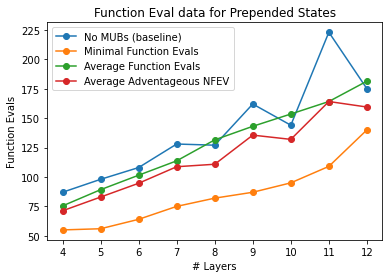

In [29]:
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_min_nfev(prepend_stats, 'Minimal Function Evals')
plot_avg_nfev(prepend_stats, 'Average Function Evals')
plot_adv_avg_nfev(prepend_stats, 'Average Adventageous NFEV')
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Function Eval data for Prepended States')
plt.legend()
plt.show()